In [ ]:
pip install xgboost

In [ ]:
pip install imblearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# 압축 파일 경로
zip_path = '/content/drive/MyDrive/open.zip'

# 압축을 풀 위치 (해당 폴더가 없으면 생성됩니다)
extract_path = '/content/drive/MyDrive/Data'

# 폴더가 없는 경우 생성
os.makedirs(extract_path, exist_ok=True)

# zipfile을 사용하여 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료!")

압축 해제 완료!


In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [44]:
train = pd.read_csv("/content/drive/MyDrive/unzipped_files/train.csv")
test = pd.read_csv("/content/drive/MyDrive/unzipped_files/test.csv")
# SUBCLASS 가 범주형이기 때문에 LabelEncoder 사용
le_subclass = LabelEncoder()
train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

In [45]:
# 변환된 레이블 확인
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")
## x 의 경우도 범주형으로 구성되어 있어, 알맞은 인코딩 필요
X = train.drop(columns=['SUBCLASS', 'ID'])
y_subclass = train['SUBCLASS']

원래 레이블: ACC, 변환된 숫자: 0
원래 레이블: BLCA, 변환된 숫자: 1
원래 레이블: BRCA, 변환된 숫자: 2
원래 레이블: CESC, 변환된 숫자: 3
원래 레이블: COAD, 변환된 숫자: 4
원래 레이블: DLBC, 변환된 숫자: 5
원래 레이블: GBMLGG, 변환된 숫자: 6
원래 레이블: HNSC, 변환된 숫자: 7
원래 레이블: KIPAN, 변환된 숫자: 8
원래 레이블: KIRC, 변환된 숫자: 9
원래 레이블: LAML, 변환된 숫자: 10
원래 레이블: LGG, 변환된 숫자: 11
원래 레이블: LIHC, 변환된 숫자: 12
원래 레이블: LUAD, 변환된 숫자: 13
원래 레이블: LUSC, 변환된 숫자: 14
원래 레이블: OV, 변환된 숫자: 15
원래 레이블: PAAD, 변환된 숫자: 16
원래 레이블: PCPG, 변환된 숫자: 17
원래 레이블: PRAD, 변환된 숫자: 18
원래 레이블: SARC, 변환된 숫자: 19
원래 레이블: SKCM, 변환된 숫자: 20
원래 레이블: STES, 변환된 숫자: 21
원래 레이블: TGCT, 변환된 숫자: 22
원래 레이블: THCA, 변환된 숫자: 23
원래 레이블: THYM, 변환된 숫자: 24
원래 레이블: UCEC, 변환된 숫자: 25


SUBCLASS
2     786
8     515
6     461
21    379
9     334
23    324
20    276
18    266
15    253
11    229
7     223
4     223
19    198
25    198
13    184
14    178
10    158
12    158
3     155
17    147
22    124
16    120
1     104
24     98
0      72
5      38
Name: count, dtype: int64


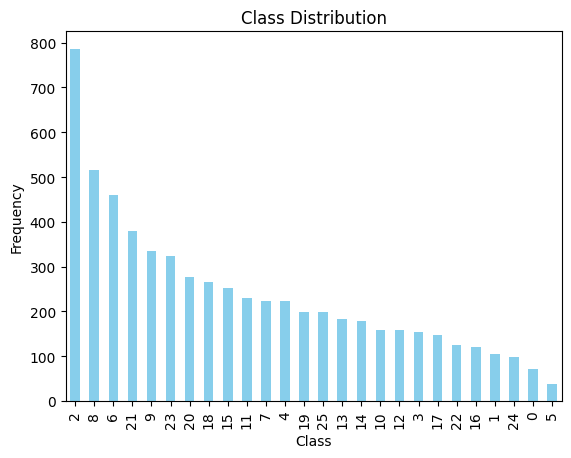

In [46]:
# 클래스 분포 확인
class_distribution = train['SUBCLASS'].value_counts()

# 출력하여 분포 확인
print(class_distribution)

# 시각화
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


In [47]:
# 각 샘플에 대한 가중치 계산
#sample_weights = np.array([class_weights_dict[label] for label in y_subclass])


In [48]:
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded = X.copy()
X_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

In [49]:
# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y_subclass)

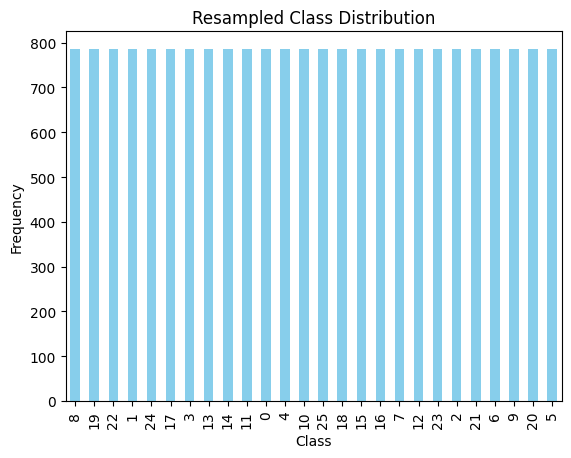

In [50]:
# SMOTE 후 클래스 분포 확인 (시각화)
resampled_distribution = pd.Series(y_resampled).value_counts()
resampled_distribution.plot(kind='bar', color='skyblue')
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [51]:
model = xgb.XGBClassifier(
    subsample=0.6,
    min_child_weight=3,
    colsample_bytree=1.0,
    n_estimators=200,
    learning_rate=0.2,
    max_depth=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1,
    min_split_loss=0.1
)

In [52]:
#model.fit(X_encoded, y_subclass, sample_weight=sample_weights)
model.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:56:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, min_split_loss=0.1,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [55]:
test_X = test.drop(columns=['ID'])
X_encoded = test_X.copy()
X_encoded[categorical_columns] = ordinal_encoder.transform(test_X[categorical_columns])
predictions = model.predict(X_encoded)
original_labels = le_subclass.inverse_transform(predictions)

In [56]:
submission = pd.read_csv("/content/drive/MyDrive/unzipped_files/sample_submission.csv")
submission["SUBCLASS"] = original_labels
submission.to_csv('./baseline_submission_reg_gamma_msl.csv', encoding='UTF-8-sig', index=False)

# RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import xgboost as xgb


In [ ]:
# 모델 설정
model = xgb.XGBClassifier(random_state=42, use_label_encoder=False)

# 하이퍼파라미터 공간 정의
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


In [ ]:
# 평가 지표 설정
f1_scorer = make_scorer(f1_score, average='weighted')

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  # 무작위 조합의 수
    scoring=f1_scorer,
    cv=5,  # 교차 검증의 폴드 수
    verbose=1,  # 진행 상태 출력
    random_state=42,
    n_jobs=-1  # 모든 코어 사용
)


In [ ]:
# 데이터 준비
X = train.drop(columns=['SUBCLASS', 'ID'])
y = train['SUBCLASS']

# 범주형 피처 인코딩
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded = X.copy()
X_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

# RandomizedSearchCV 학습
random_search.fit(X_encoded, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:40:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(f1_score, average=weighted), verbose=1)

In [ ]:
# 최적의 하이퍼파라미터와 성능 출력
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best F1 Score: 0.33717753009778867


In [ ]:
# 최적의 모델
best_model = random_search.best_estimator_

# 테스트 데이터 준비
test_X = test.drop(columns=['ID'])
test_X_encoded = test_X.copy()
test_X_encoded[categorical_columns] = ordinal_encoder.transform(test_X[categorical_columns])

# 테스트 데이터에 대한 예측
test_predictions = best_model.predict(test_X_encoded)

# 예측 결과를 파일로 저장
submission = pd.read_csv("./sample_submission.csv")
submission["SUBCLASS"] = test_predictions
submission.to_csv('./random_search_submission.csv', encoding='UTF-8-sig', index=False)


In [ ]:
submission = pd.read_csv("./random_search_submission.csv")
submission["SUBCLASS"] = original_labels
submission.to_csv('./baseline_submission_weight2.csv', encoding='UTF-8-sig', index=False)